# Part 2: Dynamic Model

In [160]:
from kafka import KafkaConsumer
import pandas as pd
import sklearn
from sklearn.metrics import confusion_matrix, f1_score

import warnings
warnings.filterwarnings("ignore")


In [165]:
import ast    
import joblib
import pickle

my_scaler = joblib.load('scaler.bin')
static_model = pickle.load(open('finalized_model.sav', 'rb'))
dynamic_model = pickle.load(open('finalized_model.sav', 'rb'))
columns_to_drop = [0,3,6,9,10,13]
window_size = 1000
consumer_data_end = 268064
threshold = 0.80

static_f1 = []
static_accuracy = []

dynamic_f1 = []
dynamic_accuracy= []

In [166]:
def preprocess(window_x, window_y):

    dfx = pd.DataFrame(window_x)
    dfy = pd.DataFrame(window_y)
    dfy = dfy.astype('int')
    dfx.drop(columns_to_drop, axis=1, inplace=True)
    dfx[11] =dfx[11].apply(hash)
    dfx[12] =dfx[12].apply(hash)

    dfx = my_scaler.transform(dfx)
    
    return dfx, dfy
    



In [167]:
consumer = KafkaConsumer(
    'ml-raw-dns',
    bootstrap_servers="localhost:9092",
    auto_offset_reset='earliest',
    enable_auto_commit=False
)

window_x = []
window_y = []
i = 0
for m in consumer:
    if i==0:
        i=i+1
        continue
    if i == consumer_data_end:
        print("data is now over, exiting..........")
        break
    if i % window_size == 1 and i!=1: #to process all lines after the first one 2-1001,1002-2001 etc
        new_x, new_y = preprocess(window_x, window_y)
        pred_static = static_model.predict(new_x)
        static_score = f1_score(new_y, pred_static)
        st_accuracy = static_model.score(new_x, new_y)

        static_f1.append(static_score)
        static_accuracy.append(st_accuracy)

        pred_dynamic = dynamic_model.predict(new_x)
        dynamic_score = f1_score(new_y, pred_dynamic)
        dy_accuracy = dynamic_model.score(new_x, new_y)

        dynamic_f1.append(dynamic_score)
        dynamic_accuracy.append(dy_accuracy)

        window_x = []
        window_y = []

        if dy_accuracy < threshold:
            print("Retraining on", i, " window")
            dynamic_model.fit(new_x, new_y)

        
    packet = ast.literal_eval(m.value.decode())
    list_packet = packet[:-1].split(',')
    window_x.append(list_packet[:-1])
    window_y.append(list_packet[-1])
    i=i+1
    




Retraining on 3001  window
Retraining on 14001  window
Retraining on 17001  window
Retraining on 18001  window
Retraining on 31001  window
Retraining on 32001  window
Retraining on 61001  window
Retraining on 77001  window
Retraining on 87001  window
Retraining on 100001  window
Retraining on 113001  window
Retraining on 115001  window
Retraining on 141001  window
Retraining on 147001  window
Retraining on 148001  window
Retraining on 149001  window
Retraining on 153001  window
Retraining on 160001  window
Retraining on 161001  window
Retraining on 186001  window
Retraining on 196001  window
Retraining on 206001  window
Retraining on 214001  window
Retraining on 225001  window
Retraining on 233001  window
Retraining on 236001  window
Retraining on 238001  window
Retraining on 248001  window
Retraining on 255001  window
Retraining on 265001  window
data is now over, exiting..........


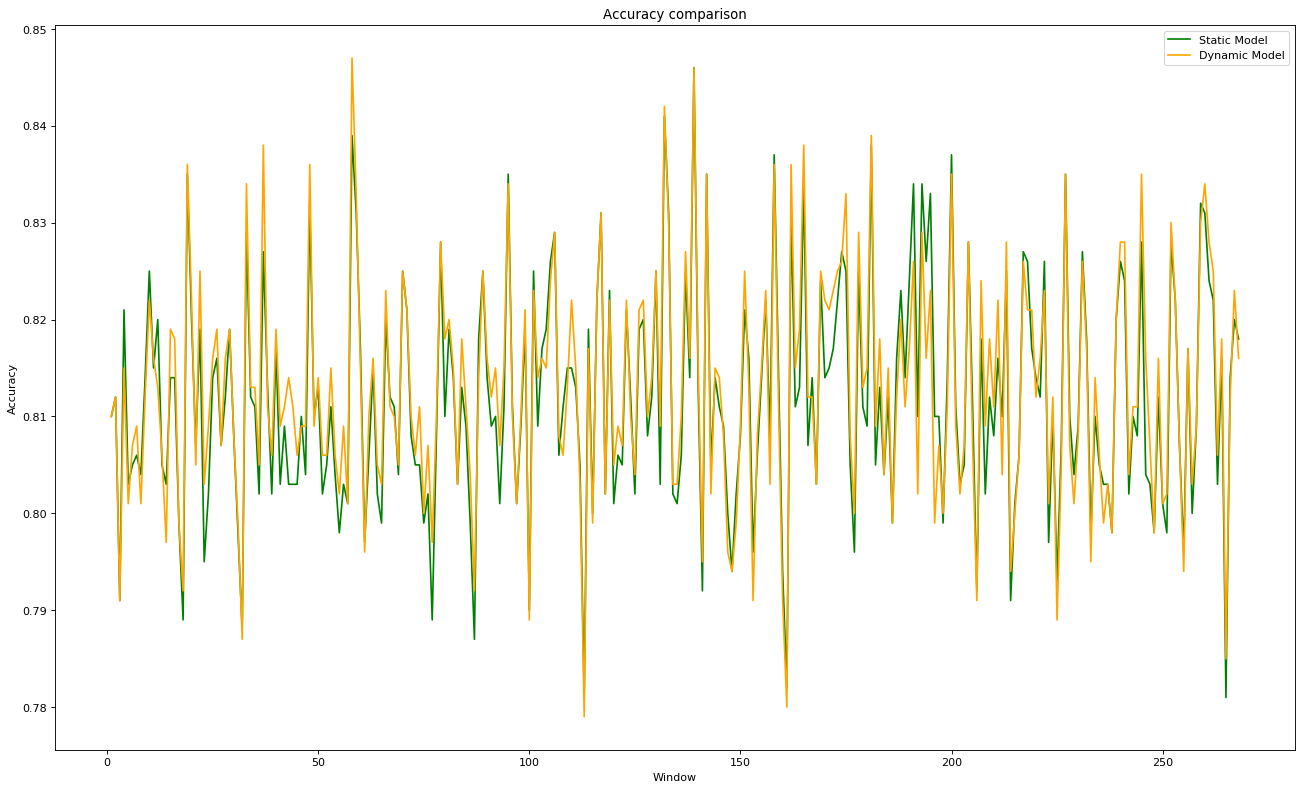

In [171]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

figure(figsize=(20, 12), dpi=80)
x = range(1, len(static_accuracy)+1)

plt.title('Accuracy comparison')
plt.plot(x, static_accuracy, 'g', label='Static Model')
plt.plot(x, dynamic_accuracy, 'orange', label='Dynamic Model')
plt.xlabel('Window')
plt.ylabel("Accuracy")
plt.legend()
# plt.figure(figsize=(1000,10000))
plt.show()

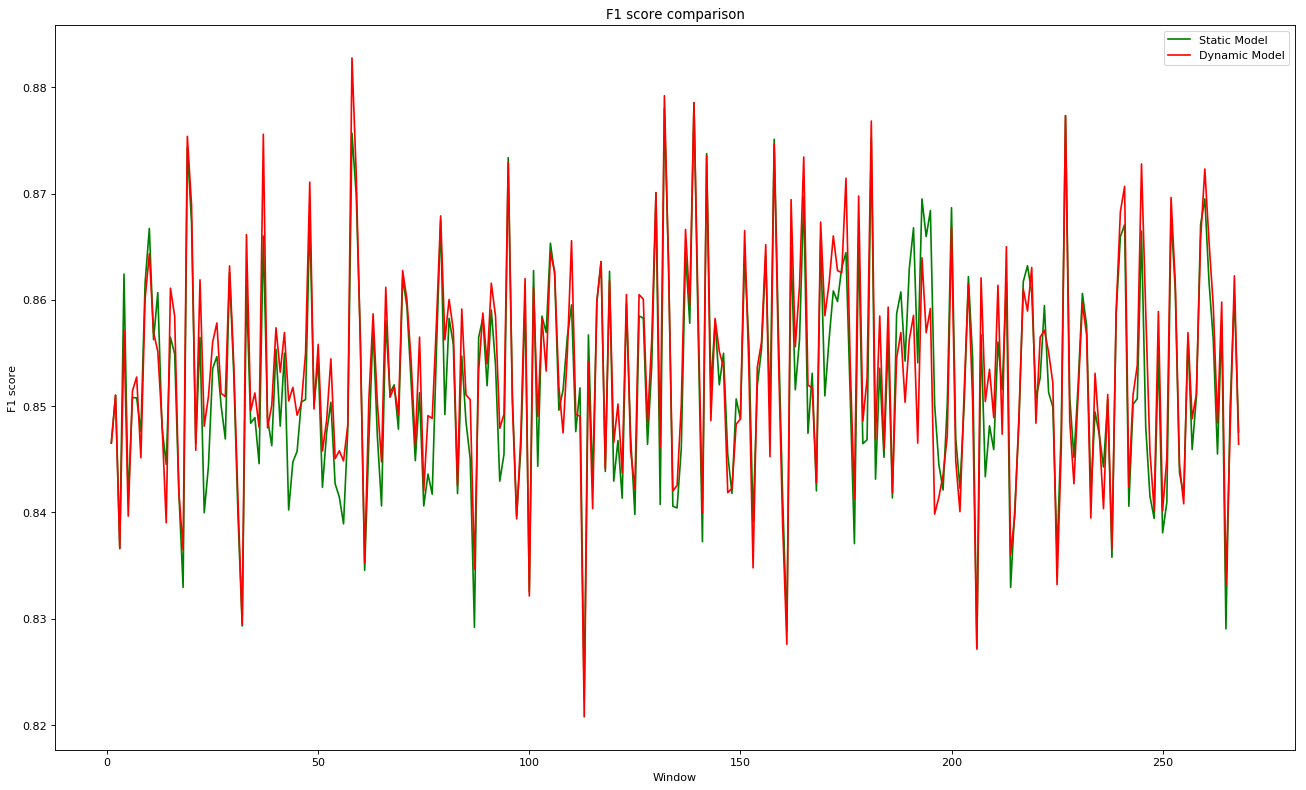

In [173]:
import matplotlib.pyplot as plt 
from matplotlib.pyplot import figure

figure(figsize=(20, 12), dpi=80)
x = range(1, len(static_accuracy)+1)

plt.title('F1 score comparison')
plt.plot(x, static_f1, 'g', label='Static Model')
plt.plot(x, dynamic_f1, 'r', label='Dynamic Model')
plt.xlabel('Window')
plt.ylabel("F1 score")
plt.legend()

plt.show()

In [151]:
result = pd.DataFrame(columns=["Data Packets Consumed","Static Score","Dynamic Score"])
result["Data Packets Consumed"] = [x*1000 for x in range (1,269)]
result["Static Score"] = static_accuracy
result["Dynamic Score"] = dynamic_accuracy
result["Static F1"] = static_f1
result["Dynamic F1"] = dynamic_f1

In [133]:
result

,Data Packets Consumed,Static Score,Dynamic Score,Static F1,Dynamic F1
0,1000,0.810,0.810,0.846527,0.846527
1,2000,0.812,0.812,0.851030,0.851030
2,3000,0.791,0.791,0.836591,0.836591
3,4000,0.821,0.815,0.862414,0.857143
4,5000,0.803,0.801,0.841001,0.839645
...,...,...,...,...,...
263,264000,0.816,0.818,0.858025,0.859784
264,265000,0.781,0.785,0.829040,0.833204
265,266000,0.814,0.812,0.850000,0.847650
266,267000,0.820,0.823,0.860465,0.862257
